# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [2]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [3]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=26.335922300033726, pvalue=1.9108523669821436e-06)


In [4]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## T-test Assumptions

<https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php>

- Independence of means

Are the means of our voting data independent (do not affect the outcome of one another)?
  
The best way to increase thel likelihood of our means being independent is to randomly sample (which we did not do).


In [0]:
from scipy.stats import ttest_ind

?ttest_ind

- "Homogeneity" of Variance? 

Is the magnitude of the variance between the two roughly the same?

I think we're OK on this one for the voting data, although it probably could be better, one party was larger than the other.

If we suspect this to be a problem then we can use Welch's T-test

- "Dependent Variable" (sample means) are Distributed Normally

<https://stats.stackexchange.com/questions/9573/t-test-for-non-normal-when-n50>

Lots of statistical tests depend on normal distributions. We can test for normality using Scipy as was shown above.

This assumption is often assumed even if the assumption is a weak one. If you strongly suspect that things are not normally distributed, you can transform your data to get it looking more normal and then run your test. This problem typically goes away for large sample sizes (yay Central Limit Theorem) and is often why you don't hear it brought up. People declare the assumption to be satisfied either way. 



## Central Limit Theorem



In [6]:
np.random.binomial(n=1, p=.5, size=30)

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1])

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

N = 1000
sample_means = []
for x in range(0,N):
  coinflips = np.random.binomial(n=1, p=.5, size=30)
  one_sample = coinflips
  sample_means.append(coinflips.mean())

print(len(sample_means))
print(sample_means)

1000
[0.5333333333333333, 0.6666666666666666, 0.6, 0.4666666666666667, 0.5666666666666667, 0.6333333333333333, 0.7, 0.5333333333333333, 0.4666666666666667, 0.5, 0.4666666666666667, 0.5666666666666667, 0.4666666666666667, 0.5666666666666667, 0.5333333333333333, 0.6, 0.6333333333333333, 0.5, 0.5333333333333333, 0.5666666666666667, 0.6, 0.6666666666666666, 0.4, 0.43333333333333335, 0.6666666666666666, 0.4666666666666667, 0.5, 0.36666666666666664, 0.6666666666666666, 0.43333333333333335, 0.4, 0.4666666666666667, 0.43333333333333335, 0.4, 0.3333333333333333, 0.43333333333333335, 0.6, 0.43333333333333335, 0.5666666666666667, 0.5, 0.5666666666666667, 0.4, 0.5333333333333333, 0.6333333333333333, 0.4666666666666667, 0.3333333333333333, 0.36666666666666664, 0.6333333333333333, 0.6, 0.43333333333333335, 0.4666666666666667, 0.5, 0.6333333333333333, 0.36666666666666664, 0.5333333333333333, 0.6, 0.5, 0.7, 0.5, 0.6, 0.5333333333333333, 0.5, 0.3333333333333333, 0.4666666666666667, 0.6333333333333333, 

In [8]:
df = pd.DataFrame({'onesamp': one_sample})
df.head()

,onesamp
0,1
1,1
2,0
3,0
4,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd180bd8668>]],
      dtype=object)

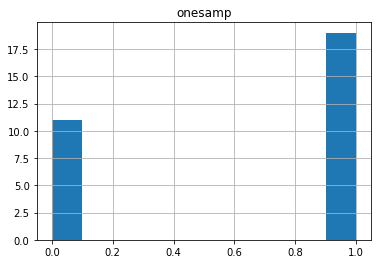

In [9]:
df.hist()

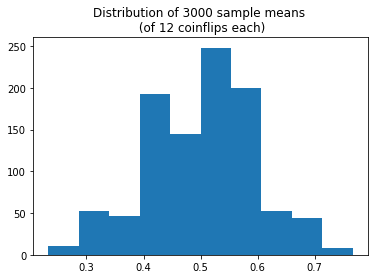

In [10]:
ax = plt.hist(sample_means)
plt.title('Distribution of 3000 sample means \n (of 12 coinflips each)');

What does the Central Limit Theorem State? That no matter the initial distribution of the population, the distribution of sample means taken will approximate a normal distribution as $n \rightarrow \infty$.

This has very important implications for hypothesis testing and is precisely the reason why the t-distribution begins to approximate the normal distribution as our sample size increases. 

## Standard Error of the Mean

What does it mean to "estimate"? the Population mean?

In [11]:
import numpy as np
import pandas as pd

# Average Height
mu = 70
sigma = 3

lambda_heights = np.random.normal(mu, sigma, 2000)
print(len(lambda_heights))
lambda_heights

2000


array([66.7118285 , 70.89345213, 70.25884906, ..., 70.71390263,
       72.0739965 , 69.41529139])

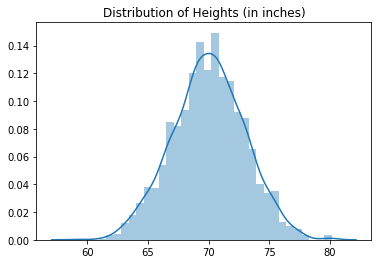

In [12]:
import seaborn as sns

sns.distplot(lambda_heights)
plt.title('Distribution of Heights (in inches)');

In [13]:
print("Population Mean:", lambda_heights.mean())
print("Population Standard Deviation:", lambda_heights.std())

Population Mean: 70.00257218564624
Population Standard Deviation: 2.986329412937294


In [14]:
population = pd.DataFrame({'heights': lambda_heights})
print(population.shape)
population.head()

(2000, 1)


,heights
0,66.711829
1,70.893452
2,70.258849
3,73.841110
4,70.325546


In [15]:
# Take a random sample and print sample mean
sample1 = population.sample(100)
print(sample1.shape)
sample1.head()

(100, 1)


,heights
91,69.939592
1763,73.083007
918,76.083989
40,72.509847
1651,65.010971


In [16]:
print('Sample Mean #1:', sample1['heights'].mean())

Sample Mean #1: 70.10479922509458


In [17]:
# Take a different random sample and print sample mean
sample2 = population.sample(100)
print(sample2.shape)
sample2.head()

(100, 1)


,heights
405,71.740405
905,73.390001
1029,70.313464
196,66.420857
760,66.215642


In [18]:
print('Sample Mean #2:', sample2['heights'].mean())

Sample Mean #2: 70.16580695644356


## Build and Interpret a Confidence Interval

<img src="https://github.com/ryanallredblog/ryanallredblog.github.io/blob/master/img/Confidence_Interval.png?raw=true" width=400>

In [19]:
coinflips_10000 = np.random.binomial(n=1, p=0.5, size=10000)

sample_std = np.std(coinflips_10000)
print('Sample St Dev:', sample_std)
sample_size = len(coinflips_10000)
print('Sample Size:', sample_size)

Sample St Dev: 0.49998318971741446
Sample Size: 10000


In [20]:
standard_error = sample_std/np.sqrt(sample_size)
print(standard_error)

0.004999831897174145


In [21]:
'''
What confidence level do we want our confidence interval to represent?¶

95% confidence Interval? 99% confidence interval?
'''

import scipy.stats as stats
help(stats.t.ppf)

Help on method ppf in module scipy.stats._distn_infrastructure:

ppf(q, *args, **kwds) method of scipy.stats._continuous_distns.t_gen instance
    Percent point function (inverse of `cdf`) at q of the given RV.
    
    Parameters
    ----------
    q : array_like
        lower tail probability
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    x : array_like
        quantile corresponding to the lower tail probability q.



In [22]:
t = stats.t.ppf(0.975, sample_size-1)
t

1.9602012636213575

In [23]:
sample_mean = coinflips_10000.mean()
confidence_interval = (sample_mean - t*standard_error, sample_mean + t*standard_error)
margin_of_error = t*standard_error

print("Sample Mean: ", sample_mean)
print("Margin of Error: ", margin_of_error)
print("Confidence Interval: ", confidence_interval)

Sample Mean:  0.4959
Margin of Error:  0.009800676802735128
Confidence Interval:  (0.4860993231972649, 0.5057006768027351)


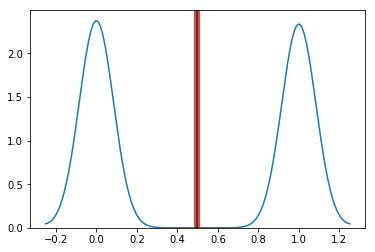

In [24]:
'''
Graphically Represent a Confidence Interval
'''

import seaborn as sns

sns.kdeplot(coinflips_10000)
plt.axvline(x=sample_mean, color='k')
plt.axvline(x=confidence_interval[0], color='r')
plt.axvline(x=confidence_interval[1], color='r')


Relationship between Confidence Intervals and T-tests

Confidence Interval == Bounds of statistical significance for our t-test

A sample mean that falls inside of our confidence interval will "FAIL TO REJECT" our null hypothesis

A sample mean that falls outside of our confidence interval will "REJECT" our null hypothesis


In [0]:
from scipy.stats import t, ttest_1samp

In [26]:
import numpy as np

coinflip_means = []
for x in range(0,100):
  coinflips = np.random.binomial(n=1, p=.5, size=30)
  coinflip_means.append(coinflips.mean())

print(coinflip_means)

[0.3333333333333333, 0.4, 0.5333333333333333, 0.43333333333333335, 0.5333333333333333, 0.5333333333333333, 0.6333333333333333, 0.5666666666666667, 0.5, 0.6333333333333333, 0.5666666666666667, 0.6333333333333333, 0.4666666666666667, 0.4666666666666667, 0.43333333333333335, 0.5, 0.6, 0.36666666666666664, 0.43333333333333335, 0.5333333333333333, 0.43333333333333335, 0.5333333333333333, 0.6333333333333333, 0.5333333333333333, 0.5333333333333333, 0.6666666666666666, 0.43333333333333335, 0.5333333333333333, 0.5, 0.4, 0.3333333333333333, 0.4666666666666667, 0.6, 0.43333333333333335, 0.7, 0.5666666666666667, 0.5333333333333333, 0.7, 0.5, 0.5666666666666667, 0.5333333333333333, 0.4666666666666667, 0.5333333333333333, 0.43333333333333335, 0.36666666666666664, 0.6, 0.43333333333333335, 0.4, 0.43333333333333335, 0.36666666666666664, 0.5, 0.5, 0.5333333333333333, 0.43333333333333335, 0.4, 0.4666666666666667, 0.5333333333333333, 0.4, 0.5, 0.4, 0.5666666666666667, 0.6333333333333333, 0.63333333333333

In [27]:
np.mean(coinflip_means)

0.5013333333333334

In [28]:
help(stats.t.interval)

Help on method interval in module scipy.stats._distn_infrastructure:

interval(alpha, *args, **kwds) method of scipy.stats._continuous_distns.t_gen instance
    Confidence interval with equal areas around the median.
    
    Parameters
    ----------
    alpha : array_like of float
        Probability that an rv will be drawn from the returned range.
        Each value should be in the range [0, 1].
    arg1, arg2, ... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information).
    loc : array_like, optional
        location parameter, Default is 0.
    scale : array_like, optional
        scale parameter, Default is 1.
    
    Returns
    -------
    a, b : ndarray of float
        end-points of range that contain ``100 * alpha %`` of the rv's
        possible values.



In [29]:
# 95% confidence interval
t_stat = stats.t.ppf(0.975, 99)
print('T Statistic: ', t_stat)

std_sample = np.std(coinflip_means)
std_err = std_sample/np.sqrt(len(coinflip_means))

CI = stats.t.interval(0.95, 99, loc=np.mean(coinflip_means), scale=std_err)
print('95% confidence interval:', CI)

T Statistic:  1.9842169515086827
95% confidence interval: (0.48368681242447736, 0.5189798542421894)


In [30]:
ttest_1samp(coinflip_means, 0.48186)

Ttest_1sampResult(statistic=2.1786524544302397, pvalue=0.03173070864170759)

In [31]:
ttest_1samp(coinflip_means, 0.51813)

Ttest_1sampResult(statistic=-1.8791902974792671, pvalue=0.06315984381679333)

In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

## Run a $\chi^{2}$ Test "by hand" (Using Numpy)

In [33]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


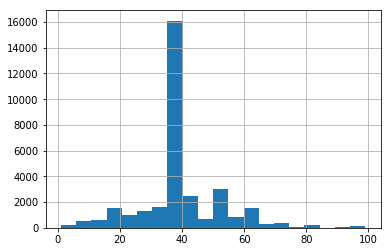

In [34]:
df['hours-per-week'].hist(bins=20);

In [35]:
df.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [36]:
cut_points = [0, 9, 19, 29, 39, 49, 500]
label_names = ['0-9','10-19','20-29','30-39','40-49','50+']
df['hours_per_week_categories'] = pd.cut(df['hours-per-week'], cut_points, labels=label_names)
df.hours_per_week_categories.value_counts()

40-49    18336
50+       6462
30-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours_per_week_categories, dtype: int64

In [37]:
df.sex.value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [38]:
df = df.sort_values(by='hours_per_week_categories')
contingency_table = pd.crosstab(df['sex'], df['hours_per_week_categories'], margins=True)
contingency_table

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


Expected Value Calculation

In [39]:
row_sums = contingency_table.iloc[0:2, 6].values
col_sums = contingency_table.iloc[2, 0:6].values

print(row_sums)
print(col_sums)

[10771 21790]
[  458  1246  2392  3667 18336  6462]


In [40]:
total = contingency_table.loc['All','All']
total

32561

In [41]:
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)
  
expected = np.array(expected)
print(expected.shape)
print(expected)

(2, 6)
[[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


Chi-Squared Statistic with Numpy

For the $observed$ values we will just use a version of our contingency table without the margins as a numpy array. In this way, if our observed values array and our expected values array are the same shape, then we can subtract them and divide them directly which makes the calculations a lot cleaner. No for loops!

In [42]:
observed = pd.crosstab(df['sex'], df['hours_per_week_categories']).values
print(observed.shape)
observed

(2, 6)


array([[  235,   671,  1287,  1914,  5636,  1028],
       [  223,   575,  1105,  1753, 12700,  5434]])

In [43]:
chi_square = ((observed - expected)**2/(expected)).sum()
chi_square

2287.190943926107

## Run a $\chi^{2}$ Test using Scipy

In [44]:
help(stats.chi2_contingency)

Help on function chi2_contingency in module scipy.stats.contingency:

chi2_contingency(observed, correction=True, lambda_=None)
    Chi-square test of independence of variables in a contingency table.
    
    This function computes the chi-square statistic and p-value for the
    hypothesis test of independence of the observed frequencies in the
    contingency table [1]_ `observed`.  The expected frequencies are computed
    based on the marginal sums under the assumption of independence; see
    `scipy.stats.contingency.expected_freq`.  The number of degrees of
    freedom is (expressed using numpy functions and attributes)::
    
        dof = observed.size - sum(observed.shape) + observed.ndim - 1
    
    
    Parameters
    ----------
    observed : array_like
        The contingency table. The table contains the observed frequencies
        (i.e. number of occurrences) in each category.  In the two-dimensional
        case, the table is often described as an "R x C table".
    

In [45]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)
print(chi_squared, p_value, dof, expected)

2287.190943926107 0.0 5 [[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [0]:
# Loading in the same data as before

cols = ['class_name', 'handicapped_infants', 'water_project_cost_sharing', 'adoption_of_budget_resolution', 'physician_fee_freeze', 'el_salvador_aid', 
        'religious_groups_in_schools', 'anti_satellite_test_ban', 'aid_to_contras', 'mx_missile', 'immigration', 'synfuels_cutback', 'education_spending', 
        'superfund_right_to_sue', 'crime', 'duty_free_exports', 'export_act_SA']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', header = None, names = cols, na_values = '?')

In [47]:
# Cleaning the data 

df.replace(to_replace = ['y','n'], value = [1,0], inplace=True)
df.fillna(0.5, inplace=True)
df.isna().sum()

class_name                       0
handicapped_infants              0
water_project_cost_sharing       0
adoption_of_budget_resolution    0
physician_fee_freeze             0
el_salvador_aid                  0
religious_groups_in_schools      0
anti_satellite_test_ban          0
aid_to_contras                   0
mx_missile                       0
immigration                      0
synfuels_cutback                 0
education_spending               0
superfund_right_to_sue           0
crime                            0
duty_free_exports                0
export_act_SA                    0
dtype: int64

In [0]:
# Let's split our data into two separate samples - Democrats and Republicans.

burros = df[df.class_name == 'democrat']
elefantes = df[df.class_name =='republican']

# and check to make sure we're not missing anything

assert len(df) == len(burros)+len(elefantes)

In [0]:
# Get a list of features we care about
features = cols
features.remove('class_name')

In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

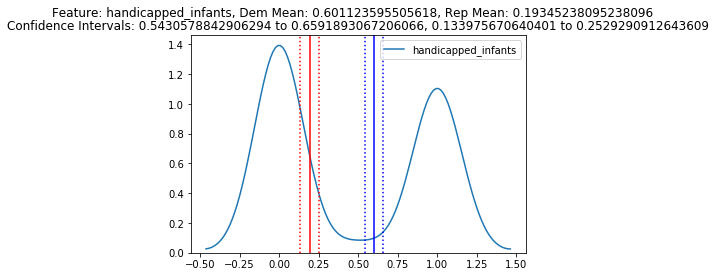

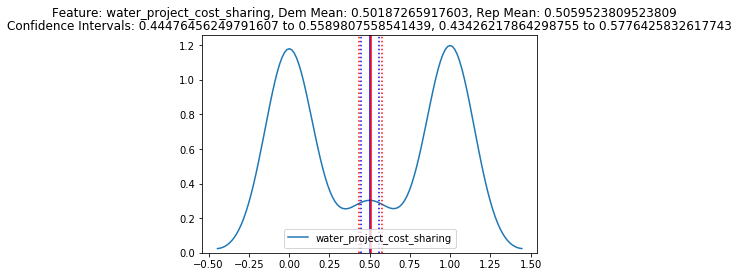

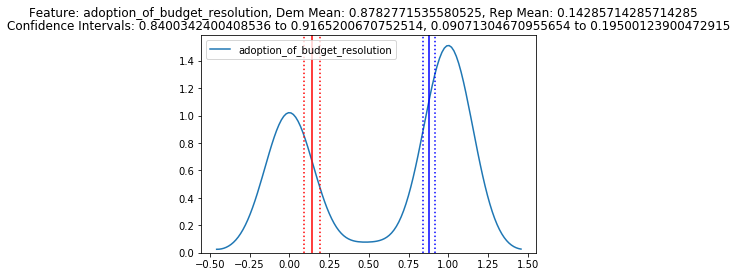

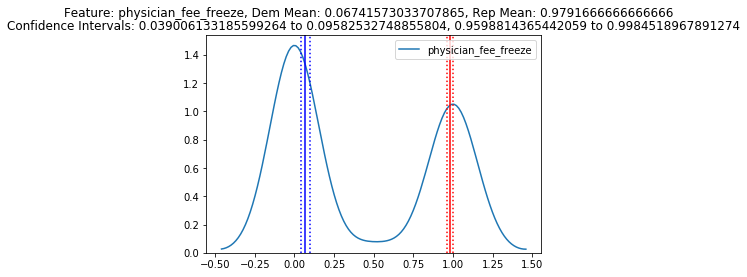

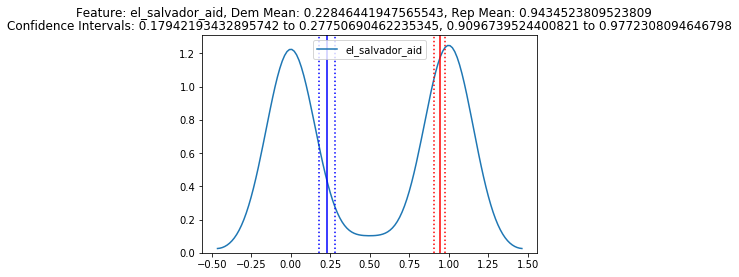

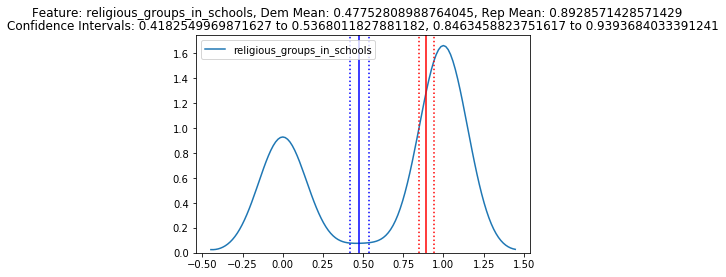

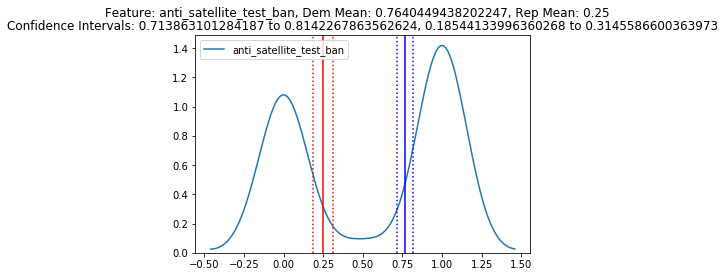

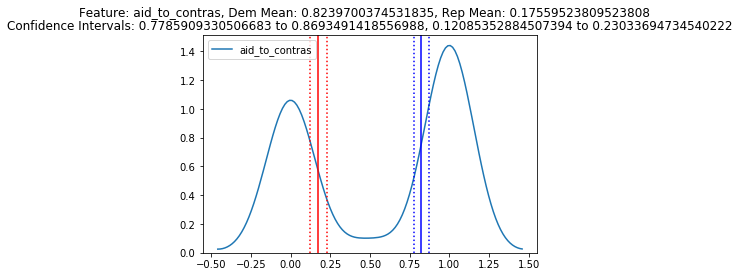

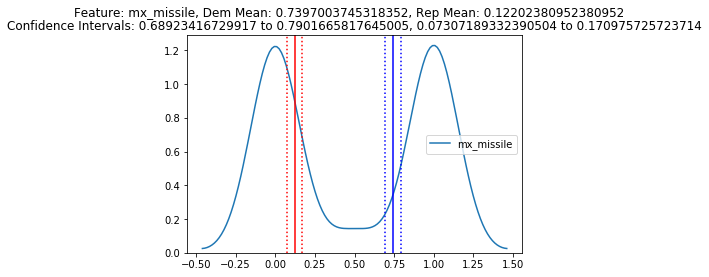

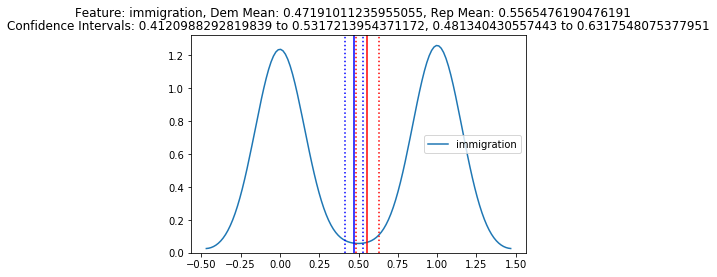

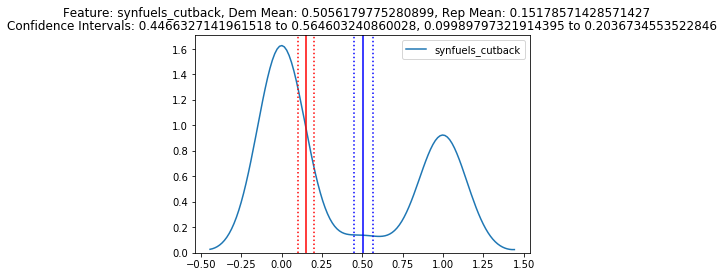

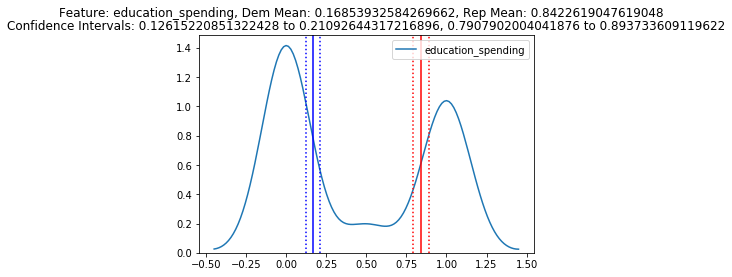

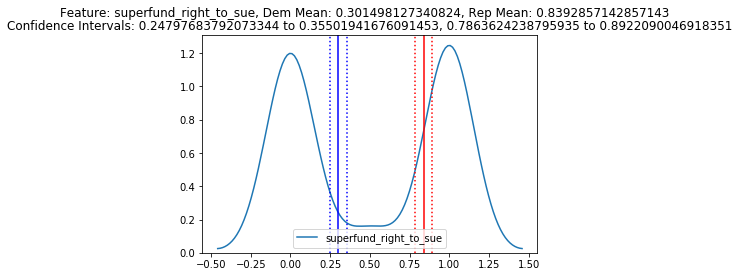

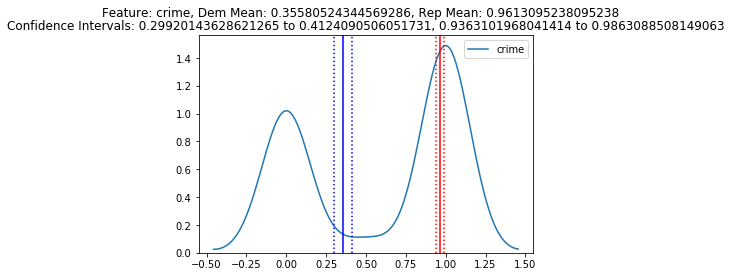

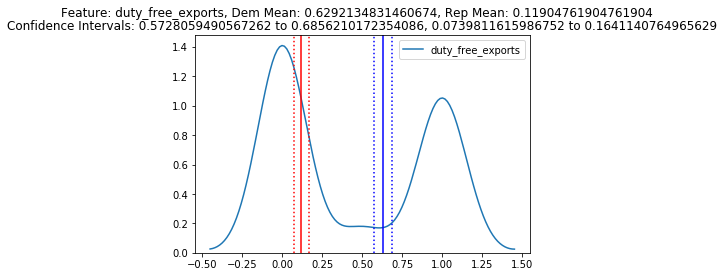

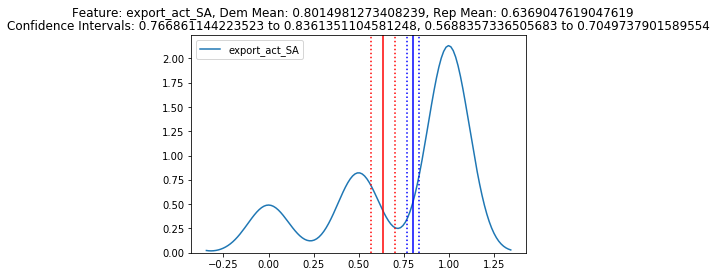

<Figure size 432x288 with 0 Axes>

In [62]:
# Generate and graphically represent confidence intervals for each feature
for feat in features:
  dmean, dlow, dhigh = confidence_interval(burros[feat])
  rmean, rlow, rhigh = confidence_interval(elefantes[feat])
  sns.kdeplot(df[feat])
  
  plt.axvline(x=dmean, color='b')
  plt.axvline(x=dlow, color='b', linestyle = ':')
  plt.axvline(x=dhigh, color='b', linestyle = ':')
  
  plt.axvline(x=rmean, color='r')
  plt.axvline(x=rlow, color='r', linestyle = ':')
  plt.axvline(x=rhigh, color='r', linestyle = ':')
  
  plt.suptitle(f'Feature: {feat}, Dem Mean: {dmean}, Rep Mean: {rmean}')
  plt.title(f'Confidence Intervals: {dlow} to {dhigh}, {rlow} to {rhigh}')
  plt.figure()

### Interpret the confidence interval - what does it tell you about the data and its distribution?

The confidence interval describes the range in which we'd expect to find the mean with a given frequency for the given distribution and a given sample size. A 95 percent confidence interval for a given result means "If run the experiment many times over, taking the mean of the same sample size, we should expect to find the mean within thiese bounds 95 percent of the time."

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)